# Modelo Predictivo de Producción de Café

Este notebook implementa un **modelo híbrido avanzado de regresión lineal** para predecir la producción anual de café por país.

## 1. Imports y Configuración

In [73]:
import pandas as pd
import numpy as np
import mysql.connector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Configuración de conexión a la base de datos
DB_CONFIG = {
    'host': 'localhost',
    'database': 'coffee',
    'user': 'analitica',
    'password': 'Operador1704'
}

print("Librerías importadas y configuración lista")

Librerías importadas y configuración lista


## 2. Carga de Datos

In [74]:
def get_connection():
    return mysql.connector.connect(**DB_CONFIG)

def load_production_data():
    print("📊 Cargando datos de producción...")
    conn = get_connection()
    
    # Cargar tabla de producción
    df_production = pd.read_sql('SELECT * FROM production', con=conn)
    df_countries = pd.read_sql('SELECT id, name FROM countries', con=conn)
    conn.close()
    
    print(f"✅ Datos cargados: {df_production.shape[0]} países")
    
    # Identificar columnas de años
    year_cols = [col for col in df_production.columns 
                 if col not in ['id', 'country_id', 'coffee_type', 'total']]
    
    print(f"📅 Años disponibles: {len(year_cols)} ({year_cols[0]} - {year_cols[-1]})")
    
    # Transformar a formato largo
    data_long = []
    for _, row in df_production.iterrows():
        country_id = row['country_id']
        for year_col in year_cols:
            year = int(year_col.split('/')[0])
            production = row[year_col]
            
            if pd.notna(production):
                data_long.append({
                    'country_id': country_id,
                    'year': year,
                    'production': production
                })
    
    df_long = pd.DataFrame(data_long)
    
    # Unir con nombres de países
    df_long = df_long.merge(df_countries.rename(columns={'id': 'country_id', 'name': 'country_name'}),
                            on='country_id', how='left')
    
    print(f"✅ Dataset transformado: {len(df_long)} registros")
    print(f"   Países únicos: {df_long['country_id'].nunique()}")
    print(f"   Rango de años: {df_long['year'].min()} - {df_long['year'].max()}")
    
    return df_long

# Cargar datos
df = load_production_data()
df.head(10)

📊 Cargando datos de producción...
✅ Datos cargados: 55 países
📅 Años disponibles: 30 (1990/91 - 2019/20)
✅ Dataset transformado: 1650 registros
   Países únicos: 55
   Rango de años: 1990 - 2019


,country_id,year,production,country_name
0,1,1990,3000000,Angola
1,1,1991,4740000,Angola
2,1,1992,4680000,Angola
3,1,1993,1980000,Angola
4,1,1994,4620000,Angola
5,1,1995,3720000,Angola
6,1,1996,4260000,Angola
7,1,1997,3840000,Angola
8,1,1998,5100000,Angola
9,1,1999,3300000,Angola


## 3. Creación de Features

Creamos dos features para el modelo:
- **year**: Captura la tendencia temporal
- **production_lag1**: Captura la inercia (producción del año anterior)

In [75]:
def create_features(df):
    print("\n🔧 Creando features (rolling + lag + momentum + interacciones)")
    
    df = df.copy()
    df = df.sort_values(['country_id', 'year'])
    
    # 1. Rolling mean: tendencia local últimos 3 años
    # Captura la tendencia promedio reciente, suavizando fluctuaciones puntuales
    df['rolling_mean_3y'] = df.groupby('country_id')['production'].transform(
        lambda x: x.rolling(window=3, min_periods=3).mean()
    )
    
    # 2. Rolling std: volatilidad últimos 3 años
    # Mide la variabilidad de la producción, útil para detectar inestabilidad
    df['rolling_std_3y'] = df.groupby('country_id')['production'].transform(
        lambda x: x.rolling(window=3, min_periods=3).std()
    )
    
    # 3. Lag1: valor más reciente (inercia)
    # La producción del año anterior es un fuerte predictor (inercia productiva)
    df['production_lag1'] = df.groupby('country_id')['production'].shift(1)
    
    # 4. Percent change: momentum del cambio
    # Captura la velocidad de cambio, indica si la producción está creciendo o decreciendo
    df['pct_change_1y'] = df.groupby('country_id')['production'].pct_change()
    
    # 5. NUEVA: Interacción tendencia x momentum (captura aceleración)
    # Detecta si países con alta producción están acelerando o desacelerando su crecimiento
    df['mean_x_pct'] = df['rolling_mean_3y'] * df['pct_change_1y']
    
    # 6. NUEVA: Volatilidad normalizada (volatilidad relativa a la escala)
    # Mide qué tan volátil es un país en relación a su nivel de producción
    df['volatility_norm'] = df['rolling_std_3y'] / (df['rolling_mean_3y'] + 1)
    
    # Limpiar infinitos y NaN
    df['pct_change_1y'] = df['pct_change_1y'].replace([np.inf, -np.inf], np.nan)
    df['mean_x_pct'] = df['mean_x_pct'].replace([np.inf, -np.inf], np.nan)
    df['rolling_std_3y'] = df['rolling_std_3y'].fillna(0)
    df['volatility_norm'] = df['volatility_norm'].replace([np.inf, -np.inf], 0).fillna(0)
    
    # Eliminar filas con NaN
    df = df.dropna(subset=['rolling_mean_3y', 'production_lag1', 'pct_change_1y', 'mean_x_pct'])
    
    print("\n✅ Features avanzadas creadas:")
    print("\n   1️⃣ rolling_mean_3y: Promedio últimos 3 años")
    print("      → Captura la tendencia promedio reciente, suavizando fluctuaciones puntuales")
    print("\n   2️⃣ rolling_std_3y: Desviación estándar últimos 3 años")
    print("      → Mide la variabilidad de la producción, útil para detectar inestabilidad")
    print("\n   3️⃣ production_lag1: Producción del año anterior")
    print("      → La producción del año anterior es un fuerte predictor (inercia productiva)")
    print("\n   4️⃣ pct_change_1y: Cambio porcentual año a año")
    print("      → Captura la velocidad de cambio, indica si está creciendo o decreciendo")
    print("\n   5️⃣ mean_x_pct: Tendencia × momentum (interacción)")
    print("      → Detecta si países con alta producción están acelerando o desacelerando")
    print("\n   6️⃣ volatility_norm: Volatilidad relativa normalizada (interacción)")
    print("      → Mide qué tan volátil es un país en relación a su nivel de producción")
    
    return df

# Crear features
df = create_features(df)
print(f"\nShape después de crear features: {df.shape}")
df.head(10)


🔧 Creando features (rolling + lag + momentum + interacciones)

✅ Features avanzadas creadas:

   1️⃣ rolling_mean_3y: Promedio últimos 3 años
      → Captura la tendencia promedio reciente, suavizando fluctuaciones puntuales

   2️⃣ rolling_std_3y: Desviación estándar últimos 3 años
      → Mide la variabilidad de la producción, útil para detectar inestabilidad

   3️⃣ production_lag1: Producción del año anterior
      → La producción del año anterior es un fuerte predictor (inercia productiva)

   4️⃣ pct_change_1y: Cambio porcentual año a año
      → Captura la velocidad de cambio, indica si está creciendo o decreciendo

   5️⃣ mean_x_pct: Tendencia × momentum (interacción)
      → Detecta si países con alta producción están acelerando o desacelerando

   6️⃣ volatility_norm: Volatilidad relativa normalizada (interacción)
      → Mide qué tan volátil es un país en relación a su nivel de producción

Shape después de crear features: (1470, 10)


,country_id,year,production,country_name,rolling_mean_3y,rolling_std_3y,production_lag1,pct_change_1y,mean_x_pct,volatility_norm
2,1,1992,4680000,Angola,4140000.0,9.877247e+05,4740000.0,-0.012658,-5.240506e+04,0.238581
3,1,1993,1980000,Angola,3800000.0,1.576452e+06,4680000.0,-0.576923,-2.192308e+06,0.414856
4,1,1994,4620000,Angola,3760000.0,1.541817e+06,1980000.0,1.333333,5.013333e+06,0.410058
5,1,1995,3720000,Angola,3440000.0,1.342088e+06,4620000.0,-0.194805,-6.701299e+05,0.390142
6,1,1996,4260000,Angola,4200000.0,4.529901e+05,3720000.0,0.145161,6.096774e+05,0.107855
7,1,1997,3840000,Angola,3940000.0,2.835489e+05,4260000.0,-0.098592,-3.884507e+05,0.071967
8,1,1998,5100000,Angola,4400000.0,6.415606e+05,3840000.0,0.328125,1.443750e+06,0.145809
9,1,1999,3300000,Angola,4080000.0,9.236883e+05,5100000.0,-0.352941,-1.440000e+06,0.226394
10,1,2000,3000000,Angola,3800000.0,1.135782e+06,3300000.0,-0.090909,-3.454545e+05,0.298890
11,1,2001,1260000,Angola,2520000.0,1.101454e+06,3000000.0,-0.580000,-1.461600e+06,0.437085


## 4. Preparación de Datos de Entrenamiento y Prueba

Dividimos los datos usando los últimos 3 años como conjunto de prueba.

In [76]:
def prepare_train_test_data(df, test_years=3):
    """Divide datos con features híbridas avanzadas"""
    print("\n📊 Dividiendo datos en train/test...")
    
    # Features: rolling + lag + momentum + interacciones
    feature_cols = ['rolling_mean_3y', 'rolling_std_3y', 'production_lag1', 
                    'pct_change_1y', 'mean_x_pct', 'volatility_norm']
    
    # División temporal
    max_year = df['year'].max()
    train_data = df[df['year'] <= max_year - test_years].copy()
    test_data = df[df['year'] > max_year - test_years].copy()
    
    X_train = train_data[feature_cols]
    y_train = train_data['production']
    X_test = test_data[feature_cols]
    y_test = test_data['production']
    
    print(f"✅ Train: {len(X_train)} muestras (años {train_data['year'].min()}-{train_data['year'].max()})")
    print(f"✅ Test:  {len(X_test)} muestras (años {test_data['year'].min()}-{test_data['year'].max()})")
    print(f"\nFeatures utilizadas ({len(feature_cols)}): {feature_cols}")
    
    return X_train, X_test, y_train, y_test, train_data, test_data

X_train, X_test, y_train, y_test, train_data, test_data = prepare_train_test_data(df)


📊 Dividiendo datos en train/test...
✅ Train: 1310 muestras (años 1992-2016)
✅ Test:  160 muestras (años 2017-2019)

Features utilizadas (6): ['rolling_mean_3y', 'rolling_std_3y', 'production_lag1', 'pct_change_1y', 'mean_x_pct', 'volatility_norm']


## 5. Entrenamiento del Modelo

Entrenamos un modelo de regresión lineal con las features creadas.

In [77]:
def train_model(X_train, y_train):

    print("\n🤖 Entrenando modelo de Regresión Lineal Avanzado...")
    print("-" * 60)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    print("\n✅ Modelo entrenado")
    print(f"   Coef. rolling_mean_3y:  {model.coef_[0]:>10.4f}")
    print(f"   Coef. rolling_std_3y:   {model.coef_[1]:>10.4f}")
    print(f"   Coef. production_lag1:  {model.coef_[2]:>10.4f}")
    print(f"   Coef. pct_change_1y:    {model.coef_[3]:>10.4f}")
    print(f"   Coef. mean_x_pct:       {model.coef_[4]:>10.4f}  ⭐ INTERACCIÓN")
    print(f"   Coef. volatility_norm:  {model.coef_[5]:>10.4f}  ⭐ INTERACCIÓN")
    print(f"   Intercepto:             {model.intercept_:>10.2f}")
    print("-" * 60)
    
    return model

model = train_model(X_train, y_train)


🤖 Entrenando modelo de Regresión Lineal Avanzado...
------------------------------------------------------------

✅ Modelo entrenado
   Coef. rolling_mean_3y:      0.1081
   Coef. rolling_std_3y:      -0.2653
   Coef. production_lag1:      0.9037
   Coef. pct_change_1y:    -7056562.3854
   Coef. mean_x_pct:           0.9146  ⭐ INTERACCIÓN
   Coef. volatility_norm:  -2960204.7122  ⭐ INTERACCIÓN
   Intercepto:              893666.00
------------------------------------------------------------


## 6. Evaluación del Modelo

Evaluamos el modelo en el conjunto de prueba usando métricas estándar.

In [78]:
def evaluate_model(model, X_test, y_test):
    # Predicciones
    y_pred = model.predict(X_test)
    
    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Calcular métricas en porcentaje
    y_mean = y_test.mean()
    mae_pct = (mae / y_mean) * 100
    rmse_pct = (rmse / y_mean) * 100
    r2_pct = r2 * 100
    
    # Ratio RMSE/MAE para detectar outliers
    rmse_mae_ratio = rmse / mae
    
    print("\n🎯 MÉTRICAS DE REGRESIÓN LINEAL")
    print("-" * 80)

    print(f"📈 RESUMEN: MAE={mae_pct:.2f}%, RMSE={rmse_pct:.2f}%, R²={r2_pct:.2f}%")

    
    # MAE
    print(f"\n📏 MAE (Mean Absolute Error) - Error Absoluto Medio:")
    print(f"   Valor absoluto:  {mae:,.2f} kg, valor relativo: {mae_pct:.2f}% de la producción media")
    print(f"💡 En promedio, las predicciones se desvían ±{mae:,.0f} kg o {mae_pct:.2f}% del valor real.")
    
    # RMSE
    print(f"\n📐 RMSE (Root Mean Squared Error) - Raíz del Error Cuadrático Medio:")
    print(f"   Valor absoluto:  {rmse:,.2f} kg, valor relativo: {rmse_pct:.2f}% de la producción media")

    print(f"\n📊 Análisis de Outliers mediante Ratio RMSE/MAE:")
    print(f"   Ratio RMSE/MAE:  {rmse_mae_ratio:.2f}")
    print(f"⚠️ Un ratio RMSE/MAE = {rmse_mae_ratio:.2f} indica presencia de outliers.")
    
    # R²
    print(f"\n📊 R² (Coeficiente de Determinación) - Varianza Explicada:")
    print(f"   Valor: {r2:.4f}")
    print(f"✅ El modelo explica el {r2_pct:.2f}% de la variabilidad en la producción.")
    print(f"✅ El {(1-r2)*100:.2f}% restante corresponde a factores no capturados (clima, políticas, plagas, etc.).")
    print("\n" + "-" * 80)

# Evaluar modelo
evaluate_model(model, X_test, y_test)


🎯 MÉTRICAS DE REGRESIÓN LINEAL
--------------------------------------------------------------------------------
📈 RESUMEN: MAE=1.36%, RMSE=2.39%, R²=99.99%

📏 MAE (Mean Absolute Error) - Error Absoluto Medio:
   Valor absoluto:  2,553,566.46 kg, valor relativo: 1.36% de la producción media
💡 En promedio, las predicciones se desvían ±2,553,566 kg o 1.36% del valor real.

📐 RMSE (Root Mean Squared Error) - Raíz del Error Cuadrático Medio:
   Valor absoluto:  4,495,219.94 kg, valor relativo: 2.39% de la producción media

📊 Análisis de Outliers mediante Ratio RMSE/MAE:
   Ratio RMSE/MAE:  1.76
⚠️ Un ratio RMSE/MAE = 1.76 indica presencia de outliers.

📊 R² (Coeficiente de Determinación) - Varianza Explicada:
   Valor: 0.9999
✅ El modelo explica el 99.99% de la variabilidad en la producción.
✅ El 0.01% restante corresponde a factores no capturados (clima, políticas, plagas, etc.).

--------------------------------------------------------------------------------


## 7. Visualización: Predicciones vs Valores Reales

Comparamos las predicciones del modelo con los valores reales para los principales países productores.

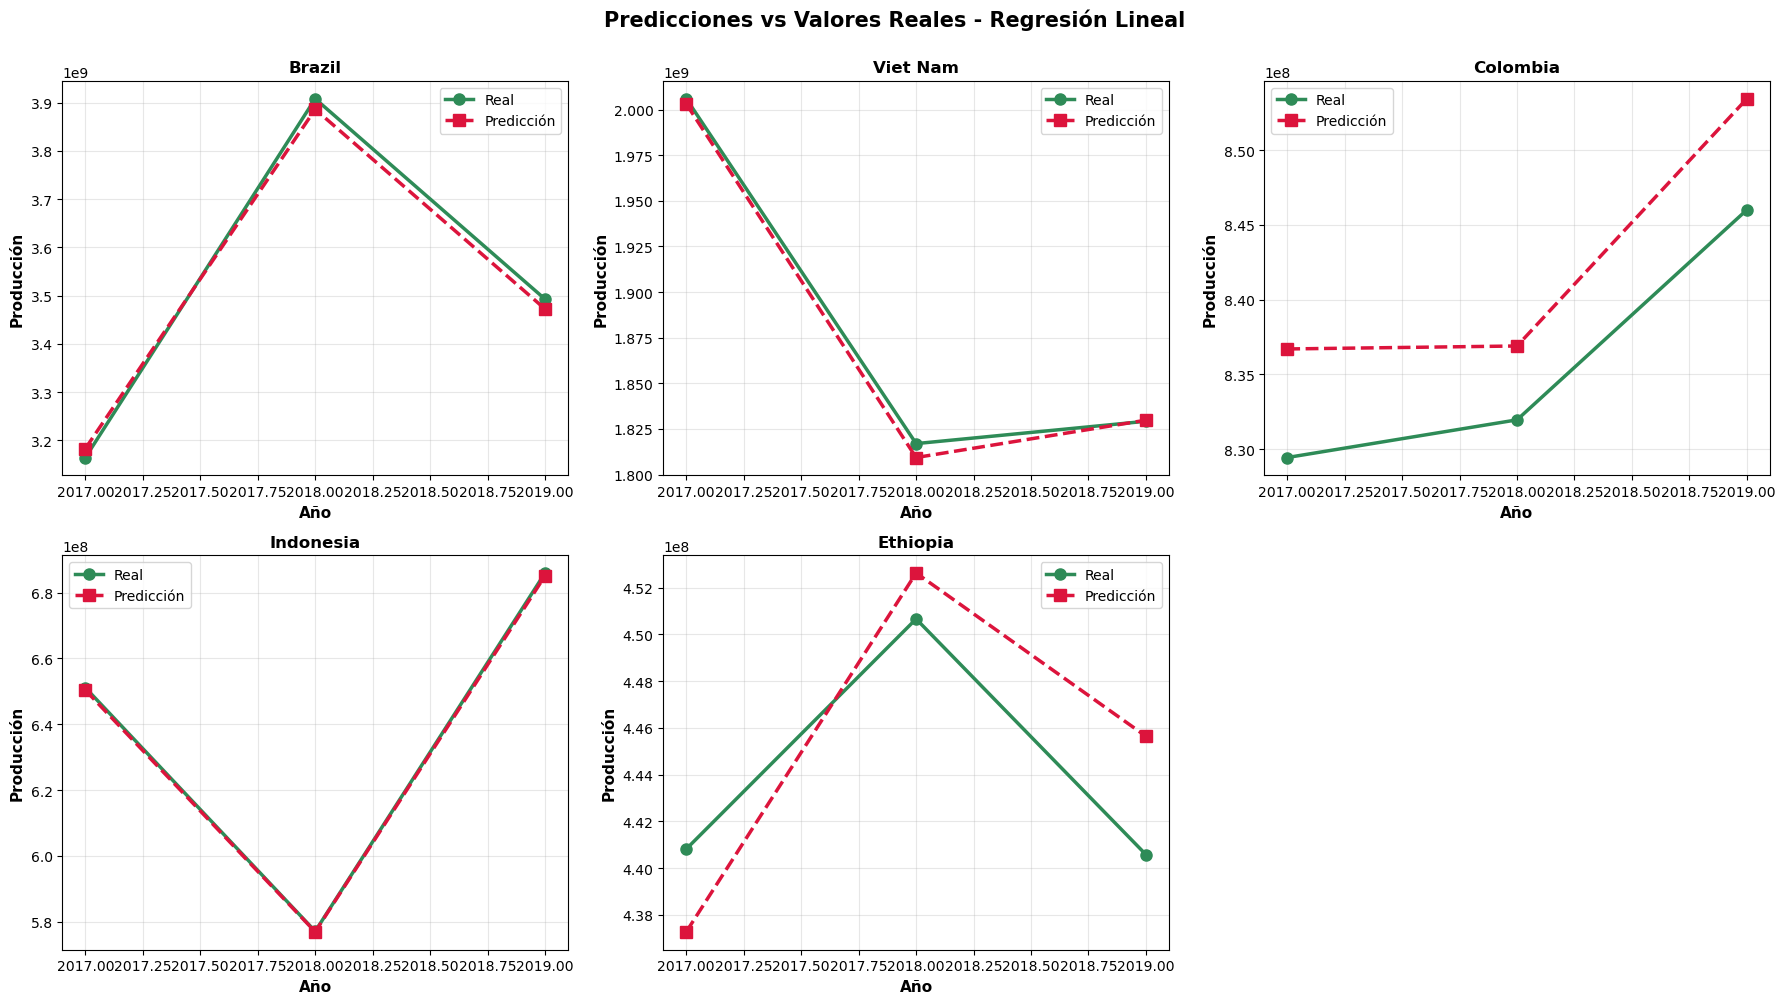

In [79]:
def plot_predictions_vs_actual(model, X_test, y_test, test_df):
    # Predecir
    y_pred = model.predict(X_test)
    
    # Crear DataFrame con resultados
    results = test_df.copy()
    results['prediction'] = y_pred
    results['actual'] = y_test.values
    
    # top 5 países por producción promedio
    top_countries = results.groupby('country_name')['actual'].mean().nlargest(5).index
    
    _, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, country in enumerate(top_countries):
        if idx >= 6:
            break
        
        country_data = results[results['country_name'] == country].sort_values('year')
        
        ax = axes[idx]
        ax.plot(country_data['year'], country_data['actual'], 
               marker='o', linewidth=2.5, markersize=8, label='Real', color='#2E8B57')
        ax.plot(country_data['year'], country_data['prediction'], 
               marker='s', linewidth=2.5, markersize=8, label='Predicción', 
               color='#DC143C', linestyle='--')
        
        ax.set_xlabel('Año', fontsize=11, fontweight='bold')
        ax.set_ylabel('Producción', fontsize=11, fontweight='bold')
        ax.set_title(f'{country}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    # Ocultar ejes sobrantes
    for idx in range(len(top_countries), 6):
        axes[idx].axis('off')
    
    plt.suptitle('Predicciones vs Valores Reales - Regresión Lineal', 
                 fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

# Visualizar predicciones vs valores reales
plot_predictions_vs_actual(model, X_test, y_test, test_data)

## 8. Predicción de Producción Futura

Usamos el modelo entrenado para predecir la producción de café en los próximos 5 años (2020-2024).

In [89]:
def predict_future_production(model, df, years_ahead=5):
    """Predice producción futura usando features híbridas avanzadas"""
    print(f"\n🔮 Prediciendo producción para los próximos {years_ahead} años...")
    print("-" * 60)
    
    latest_year = df['year'].max()
    predictions = []
    
    # Para cada país, mantener histórico actualizado
    for country_id in df['country_id'].unique():
        country_data = df[df['country_id'] == country_id].sort_values('year').copy()
        country_name = country_data['country_name'].iloc[0]
        
        # Histórico de producción para rolling calculations
        production_history = country_data['production'].tolist()
        for year in range(1, years_ahead + 1):
            pred_year = latest_year + year
            
            # Calcular features basadas en últimos valores
            recent_3 = production_history[-3:]
            rolling_mean = np.mean(recent_3)
            rolling_std = np.std(recent_3)
            prod_lag1 = production_history[-1]
            
            # Calcular pct_change evitando división por cero
            if production_history[-2] != 0 and prod_lag1 != 0:
                pct_change = (prod_lag1 - production_history[-2]) / production_history[-2]
            else:
                pct_change = 0.0
            
            # Features de interacción
            mean_x_pct = rolling_mean * pct_change
            volatility_norm = rolling_std / (rolling_mean + 1) if rolling_mean > 0 else 0
            
            # Predecir con todas las features
            X_pred = np.array([[rolling_mean, rolling_std, prod_lag1, pct_change, mean_x_pct, volatility_norm]])
            pred = model.predict(X_pred)[0]
            
            # Si la predicción es negativa, usar promedio de últimos 3 años
            if pred < 0:
                pred = rolling_mean
            
            predictions.append({
                'country_id': country_id,
                'country_name': country_name,
                'year': pred_year,
                'predicted_production': pred
            })
            
            # Actualizar histórico con la predicción
            production_history.append(pred)
        
    print(f"   ✓ Predicciones completadas para {latest_year + 1}-{latest_year + years_ahead}")
    print("-" * 60)
    return pd.DataFrame(predictions)

future_predictions = predict_future_production(model, df, years_ahead=5)
future_predictions.head(10)


🔮 Prediciendo producción para los próximos 5 años...
------------------------------------------------------------
   ✓ Predicciones completadas para 2020-2024
------------------------------------------------------------


,country_id,country_name,year,predicted_production
0,1,Angola,2020,2.282336e+06
1,1,Angola,2021,3.999053e+06
2,1,Angola,2022,8.461718e+05
3,1,Angola,2023,3.817597e+06
4,1,Angola,2024,2.887607e+06
5,5,Bolivia (Plurinational State of),2020,5.817801e+06
6,5,Bolivia (Plurinational State of),2021,5.910502e+06
7,5,Bolivia (Plurinational State of),2022,6.420360e+06
8,5,Bolivia (Plurinational State of),2023,7.018035e+06
9,5,Bolivia (Plurinational State of),2024,7.497121e+06


## 9. Visualización: Predicciones Futuras

Visualizamos las predicciones futuras junto con el histórico de producción para los principales países productores.

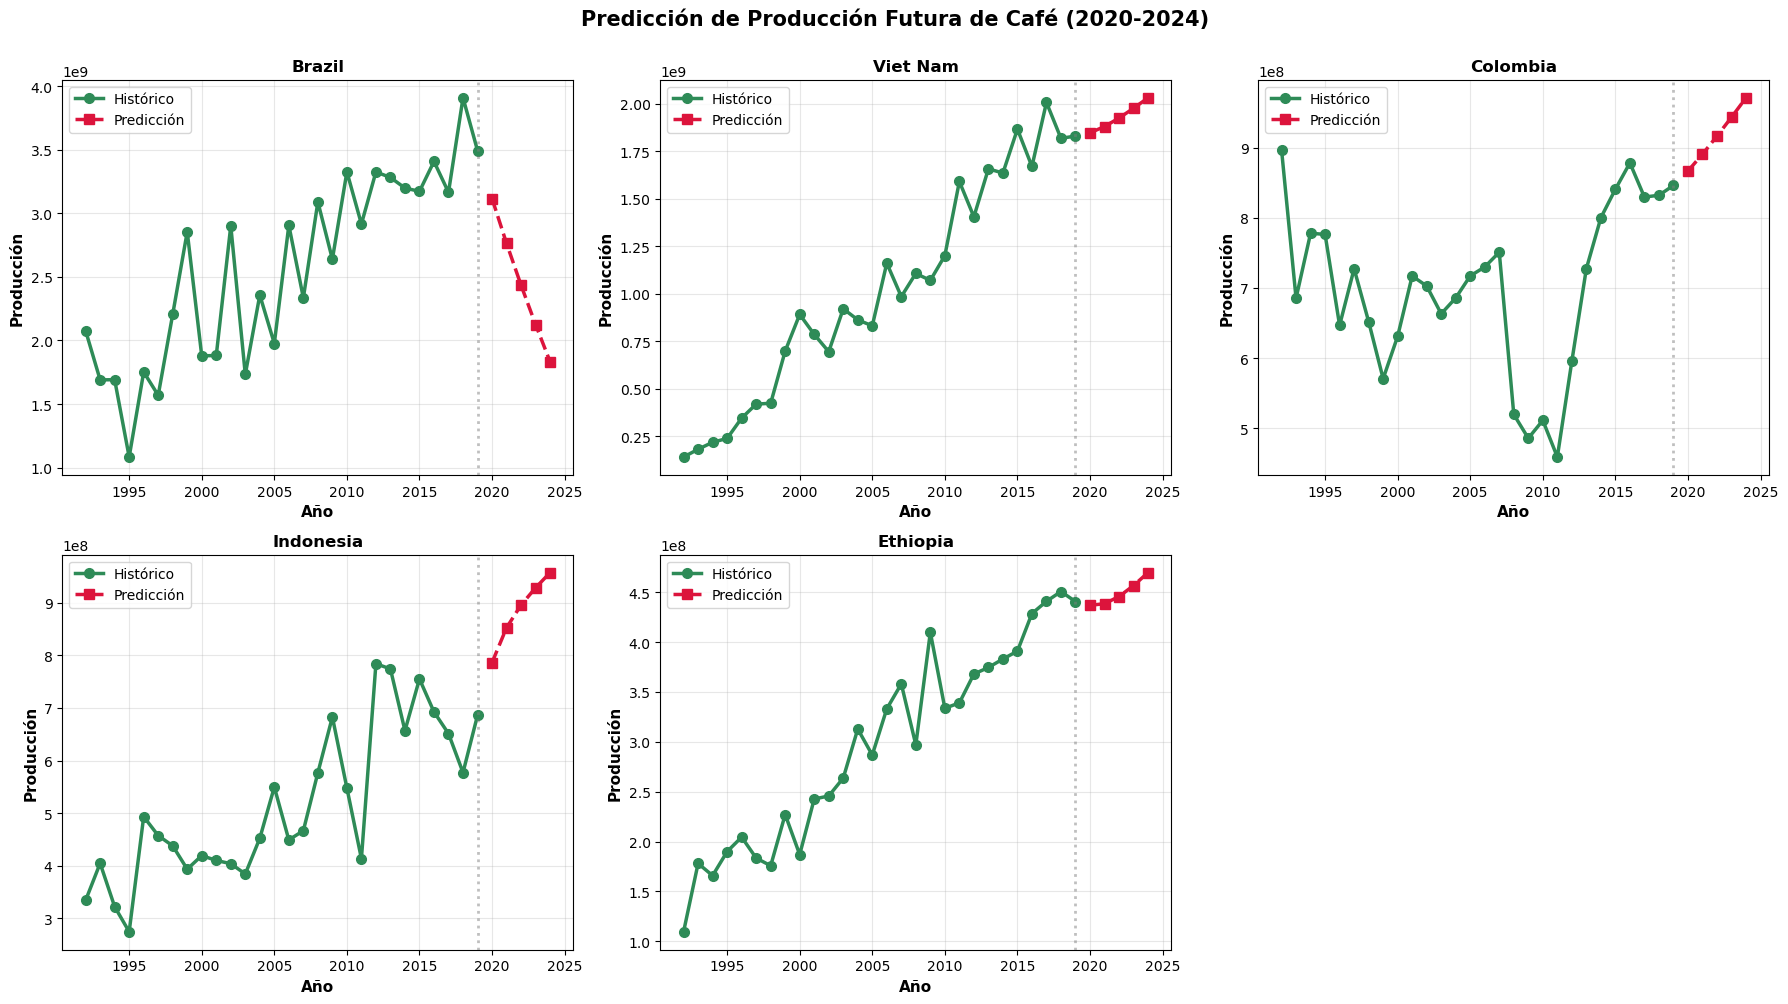

In [81]:
def plot_future_predictions(df, future_df, top_n=5):
    # Seleccionar top países por producción histórica
    top_countries = df.groupby('country_name')['production'].mean().nlargest(top_n).index
    
    _, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, country in enumerate(top_countries):
        if idx >= 6:
            break
        
        ax = axes[idx]
        
        # Datos históricos
        historical = df[df['country_name'] == country].sort_values('year')
        ax.plot(historical['year'], historical['production'], 
               marker='o', linewidth=2.5, markersize=7, label='Histórico', 
               color='#2E8B57')
        
        # Predicciones futuras
        future = future_df[future_df['country_name'] == country].sort_values('year')
        ax.plot(future['year'], future['predicted_production'], 
               marker='s', linewidth=2.5, markersize=7, label='Predicción', 
               color='#DC143C', linestyle='--')
        
        # Línea vertical separando histórico de predicción
        if len(future) > 0:
            ax.axvline(x=historical['year'].max(), color='gray', 
                      linestyle=':', linewidth=2, alpha=0.5)
        
        ax.set_xlabel('Año', fontsize=11, fontweight='bold')
        ax.set_ylabel('Producción', fontsize=11, fontweight='bold')
        ax.set_title(f'{country}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    # Ocultar ejes sobrantes
    for idx in range(len(top_countries), 6):
        axes[idx].axis('off')
    
    plt.suptitle('Predicción de Producción Futura de Café (2020-2024)', 
                 fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

# Visualizar predicciones futuras
plot_future_predictions(df, future_predictions, top_n=5)